## Deep learning: Time Series forecasting

The goal of this project is to forecast the pollution at the next hour given history of pollution and weather condition. 

 #### Import Libraries

In [2]:
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime

# Ignore deprecated warning
#import warnings
#warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(42) # to make this notebook's output identical at every run
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU

#### Dataset 
The dataset (https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv) is collected from the US embassy in Beijing, China. It reports the Air quality and the weather each hour for five years.
The data including the pollutant (PM2.5 concentration) to be forecast is described with variables listed below:
* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* pm2.5: PM2.5 concentration
* DEWP: Dew Point
* TEMP: Temperature
* PRES: Pressure
* cbwd: Combined wind direction
* Iws: Cumulated wind speed
* Is: Cumulated hours of snow
* Ir: Cumulated hours of rain




#### Load Dataset

In [3]:
data = pd.read_csv('pollution.csv')
# Display the first (5) rows of the dataframe 
data.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
# Missing values (NA) for all the columns
data.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [5]:
# Data types for each column 
data.dtypes

No         int64
year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
dtype: object

In [6]:
#Check variable cbwd value occurences using value_counts
data['cbwd'].value_counts()

SE    15290
NW    14150
cv     9387
NE     4997
Name: cbwd, dtype: int64

#### Reload, preprocess and visualize data

In [7]:
# Load & format date
data = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=lambda d: datetime.strptime(d, '%Y %m %d %H'))
# Drop No(variable) column
data.drop(columns=['No'], inplace=True)
# Fill all the NA with value  0
data.fillna(0, inplace=True)
# label encodeing of cbwd (wind direction feature): categories to numeric value
le = LabelEncoder()
data['cbwd'] = le.fit_transform(data['cbwd'])
# rename columns
data.rename(columns = {"pm2.5":"pollution","cbwd":"WINDdir","Iws":"WINDsped",	"Is":"SNOW",	"Ir":"RAIN"}, inplace=True)
data.index.name = 'datetime'
data.head()

,pollution,DEWP,TEMP,PRES,WINDdir,WINDsped,SNOW,RAIN
datetime,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1,12.97,0,0


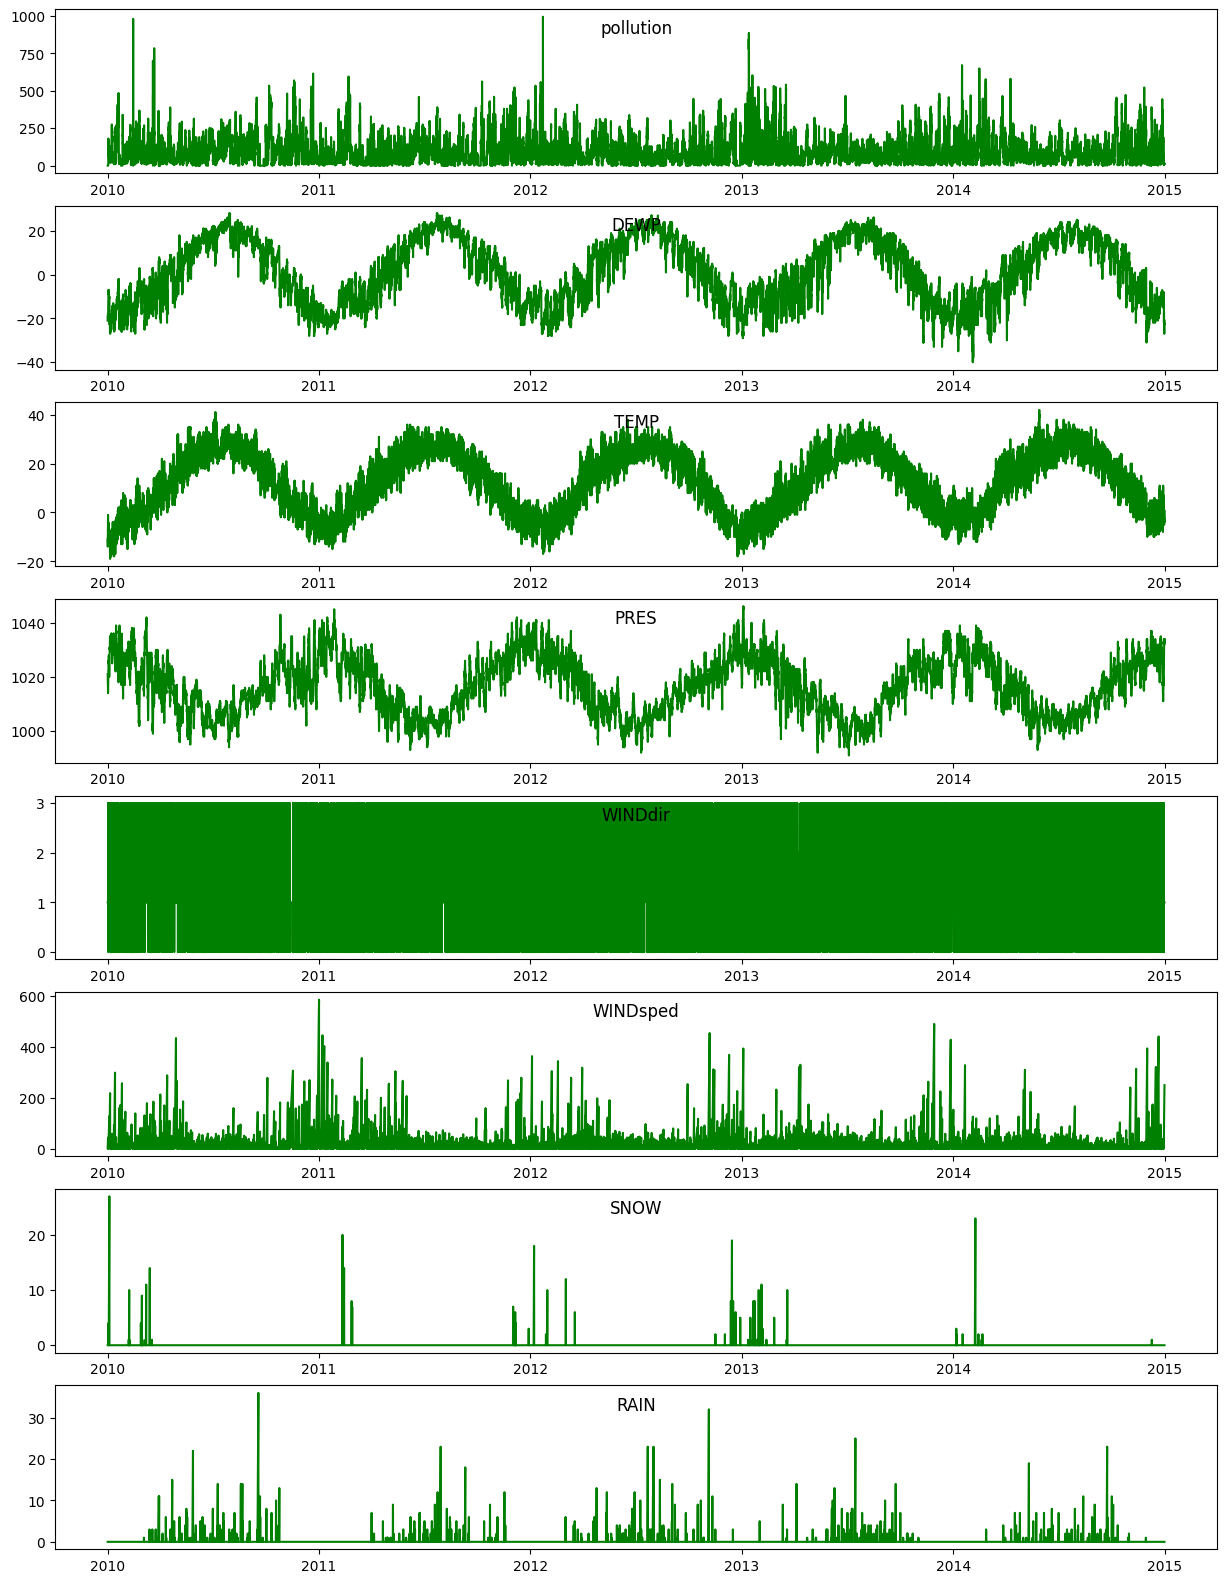

In [8]:
plt.figure(figsize=(15,20))
list_vars = data.columns #("pollution",	"DEWP",	"TEMP",	"PRES",	"WINDsped",	"SNOW",	"RAIN")
for i, var in enumerate(list_vars):
  plt.subplot(data.shape[1], 1, i+1)
  plt.plot(data[var], color='green')
  plt.title(var,y=0.8)

<AxesSubplot: >

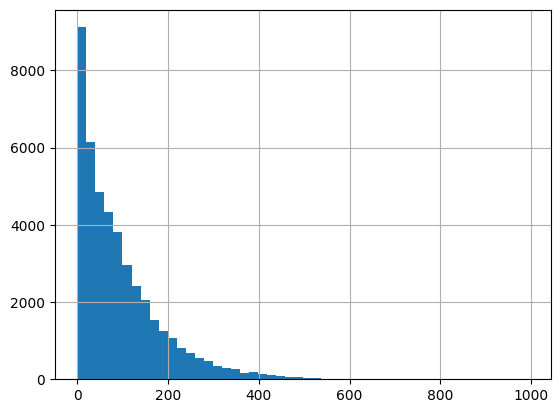

In [9]:
# histogram for pollution
data.pollution.hist(bins=50)

### Time series forecasting as supervised learning problem (Regression setting)
We predict the pollution at the next hour (t) given the pollution and weather conditions at the prior time step. 


#### Prepare the pollution dataset for LSTM algorithm

In [10]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target=None):
  # History: look-back sequences (t-n, ... t-1)
  stack_history = []
  for i in range(n_history,0,-1):
    df_i = df.shift(i)
    df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
    stack_history =  stack_history + [df_i]
  # target dataframe
  if target is None: df_target = df
  else: df_target = df[target].to_frame()
  # Horizon: step-ahead sequences (t+1, ... t+n)
  stack_horizon = []
  for j in range(n_horizon,0,-1):
    df_j = df_target.shift(j) 
    df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
    stack_horizon = [df_j] + stack_horizon
  # Present: t
  df_t = df.copy()
  df_t.columns = [f'{col}_t' for col in df_t.columns]
  # return the concatenated data frame: past+present+future
  return pd.concat(stack_history+[df_t]+stack_horizon, axis=1)

In [11]:
data_Xy = history_and_horizon_sequencing(data, 3, 1, target='pollution')
print(data_Xy.shape)
data_Xy.dropna(inplace=True)
print(data_Xy.shape)
data_Xy.head()

(43824, 33)
(43821, 33)


,pollution_t-3,DEWP_t-3,TEMP_t-3,PRES_t-3,WINDdir_t-3,WINDsped_t-3,SNOW_t-3,RAIN_t-3,pollution_t-2,DEWP_t-2,...,RAIN_t-1,pollution_t,DEWP_t,TEMP_t,PRES_t,WINDdir_t,WINDsped_t,SNOW_t,RAIN_t,pollution_t+1
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 03:00:00,0.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,0.0,-21.0,...,0.0,0.0,-21,-14.0,1019.0,1,9.84,0,0,0.0
2010-01-01 04:00:00,0.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,0.0,-21.0,...,0.0,0.0,-20,-12.0,1018.0,1,12.97,0,0,0.0
2010-01-01 05:00:00,0.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,0.0,-21.0,...,0.0,0.0,-19,-10.0,1017.0,1,16.10,0,0,0.0
2010-01-01 06:00:00,0.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,0.0,-20.0,...,0.0,0.0,-19,-9.0,1017.0,1,19.23,0,0,0.0
2010-01-01 07:00:00,0.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,0.0,-19.0,...,0.0,0.0,-19,-9.0,1017.0,1,21.02,0,0,0.0


#### Baseline v0: persistance modeling
Use observation from the present time step (t) to predict the observation at the next time step (t+1).   

A persistence model, also known as a naive model or benchmark model, is a simple forecasting model that uses historical data to predict future values by assuming that the future values will be the same as the most recent observed value.

In [12]:
def baseline_persistance(serie_t):
    # forecast: predict t+1 with value of t
    forecast = serie_t.shift(1)
    return forecast

def compute_performance(test, forecast, start_t=400, end_t=500):
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print('RMSE: %.3f' % rmse)
    plt.style.use('ggplot')
    plt.figure(figsize=(15,5))
    plt.plot(test[start_t:end_t], color='b', label = 'test')
    plt.plot(forecast[start_t:end_t], color='r', label ='forecast')
    plt.legend()

RMSE: 27.568


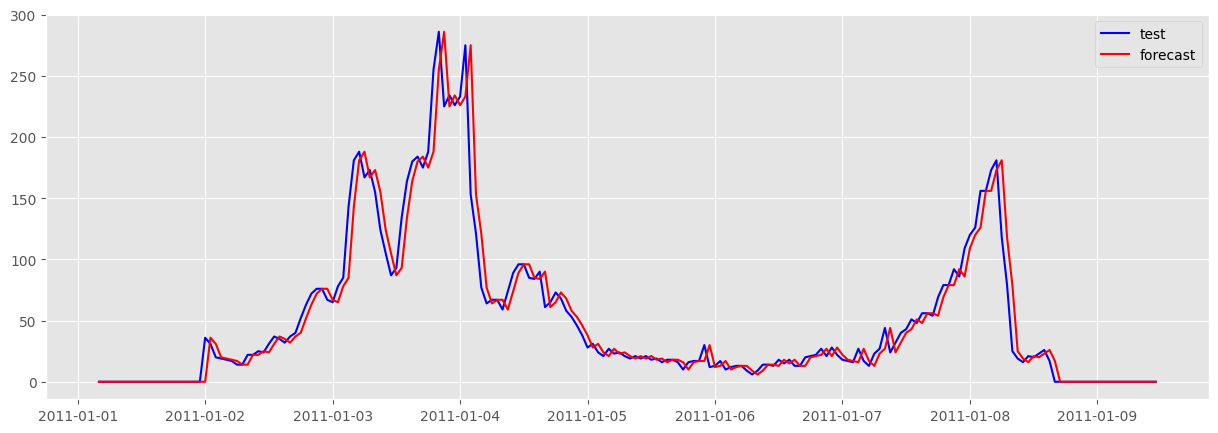

In [13]:
test_y, persistance_yhat = data_Xy['pollution_t'][1:], baseline_persistance(data_Xy['pollution_t'])[1:] 
compute_performance(test_y, persistance_yhat, start_t=365*24, end_t=365*24+200)

## LSTM model

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture, designed to capture long-term dependencies and patterns in sequential data. It is commonly used for sequence data modeling, such as time series forecasting or natural language processing tasks. Some advantages and disadvantages of using LSTMs:

### Advantages
* Long-term dependencies: LSTMs are designed to address the vanishing gradient problem, which is a common issue in training deep neural networks. LSTM incorporates specialized memory cells that can capture and retain information over longer sequences, allowing it to model and capture long-term dependencies in sequential data.
* Flexibility and adaptability: LSTMs are a flexible architecture that can be used for a wide range of sequence data modeling tasks. They can handle input sequences of varying lengths and can learn to capture patterns in the data, making it adaptable to different types of sequential data, including time series data, text data, and more.
* Non-linear modeling: LSTMs introduce non-linear activations and gates (such as the sigmoid and tanh activations) that allow for model complex relationships and patterns in the data. This makes them capable of capturing non-linear dependencies and patterns in sequential data, which may not be easily captured by other linear models.

### Disadvantages
* Computational complexity: LSTM can be computationally expensive, especially when dealing with large datasets or complex architectures. Training and inference times can be longer compared to simpler models, which may impact the efficiency of real-time or resource-constrained applications.
* Risk of overfitting: Like other deep learning models, LSTM is prone to overfitting, especially when dealing with small datasets. Careful regularization techniques such as dropout, regularization, and early stopping may be required to mitigate overfitting risks and improve model generalization.
* Hyperparameter tuning: LSTM requires careful tuning of hyperparameters, such as the number of LSTM layers, number of hidden units learning rate, and batch size, to achieve optimal performance. Finding the best hyperparameter configuration can be time-consuming and may require experimentation and fine-tuning.


#### Split data into train and test sets 
Build training and testing dataset for model training on the first year and predict the outcome for the subsequent four years

In [14]:
def split_train_test(values, n_train_hours=365*24):
    # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features] required for LSTM
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y

In [15]:
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values)

(8760, 1, 32) (8760,) (35061, 1, 32) (35061,)


#### Build LSTM model

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

def build_lstm_model(input_shape, nb_neurons=50):
  '''
  train and test: input shape 1 time step with 8 features
  LSTM:
   * nb_neurons: hidden state
   * 1 neuron for output layer for prediction.
  '''
  model = Sequential()
  # Add an LSTM layer with nb_neurons and input_shape=input_shape
  model.add(LSTM(nb_neurons, input_shape=input_shape))
  # Add a Dense layer with one output neuron
  model.add(Dense(1))
  # model compile
  model.compile(loss='mae', optimizer='adam')
  # Train the model
  return model


def train_model(model, train_X, train_y, test_X, test_y, epochs=500, batch_size=72, verbose=0):
  '''
  Generic function to train model
  '''
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=verbose, shuffle=False)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.xlabel("Epoch", fontsize=14)
  plt.ylabel("Loss", fontsize=14)
  plt.legend()
  plt.show()

2023-12-31 18:40:53.807002: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-12-31 18:40:53.807053: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-31 18:40:53.807558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
122/122 [==============================] - 5s 21ms/step - loss: 93.7793 - val_loss: 90.0967
Epoch 2/100
122/122 [==============================] - 2s 15ms/step - loss: 92.3561 - val_loss: 88.6240
Epoch 3/100
122/122 [==============================] - 2s 16ms/step - loss: 90.8393 - val_loss: 86.9762
Epoch 4/100
122/122 [==============================] - 2s 13ms/step - loss: 89.4493 - val_loss: 85.5543
Epoch 5/100
122/122 [==============================] - 2s 16ms/step - loss: 88.1354 - val_loss: 84.2321
Epoch 6/100
122/122 [==============================] - 2s 16ms/step - loss: 86.8956 - val_loss: 83.0075
Epoch 7/100
122/122 [==============================] - 1s 12ms/step - loss: 85.7325 - val_loss: 81.8909
Epoch 8/100
122/122 [==============================] - 2s 15ms/step - loss: 84.6493 - val_loss: 80.8523
Epoch 9/100
122/122 [==============================] - 2s 15ms/step - loss: 83.6256 - val_loss: 79.8931
Epoch 10/100
122/122 [==============================] - 2s 15ms/

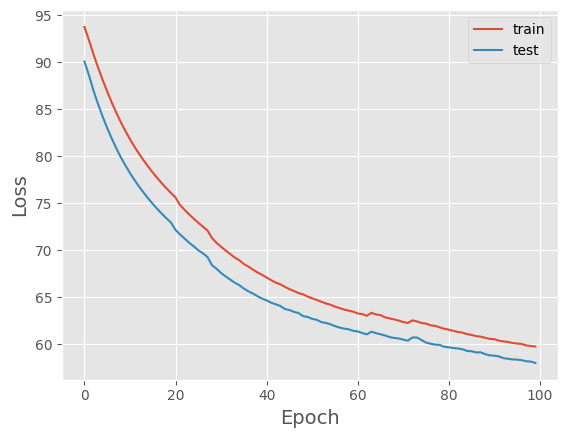

In [17]:
# Build and train the model
input_shape=(train_X.shape[1], train_X.shape[2])
# Build and train the model using the build_lstm_model (new instance lstm_model)
lstm_model = build_lstm_model(input_shape)
# Train the new model using train_model method with params lstm_model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=0
train_model(lstm_model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=1)

1096/1096 [==============================] - 4s 3ms/step
RMSE: 91.250


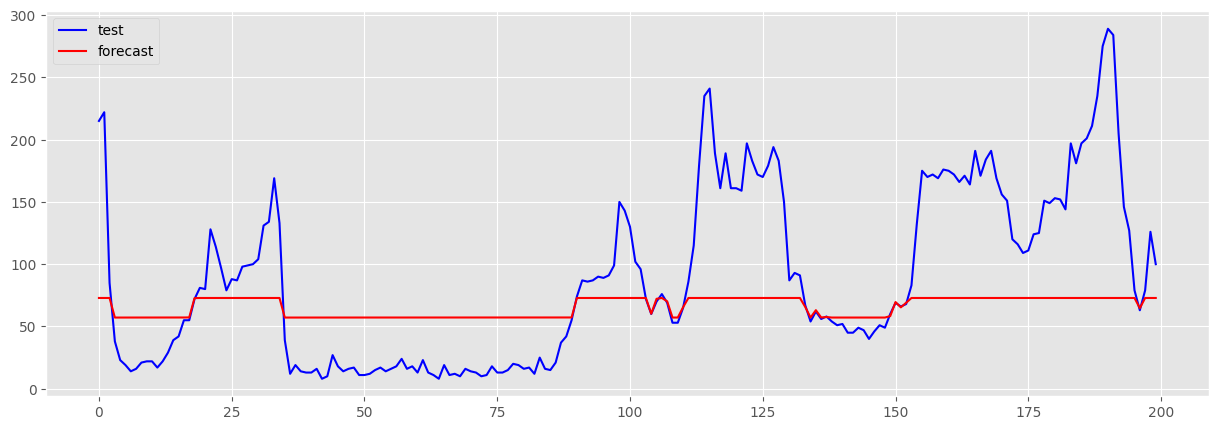

In [18]:
# make the prediction of test_X (store in lstm_yhat)
lstm_yhat = lstm_model.predict(test_X)
# compute performance
compute_performance(test_y, lstm_yhat, start_t=365*24, end_t=365*24+200)

#### LSTM trained with scaled data

In [19]:
# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
# Create train/tests datasets from scaled_data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values)

(8760, 1, 32) (8760,) (35061, 1, 32) (35061,)


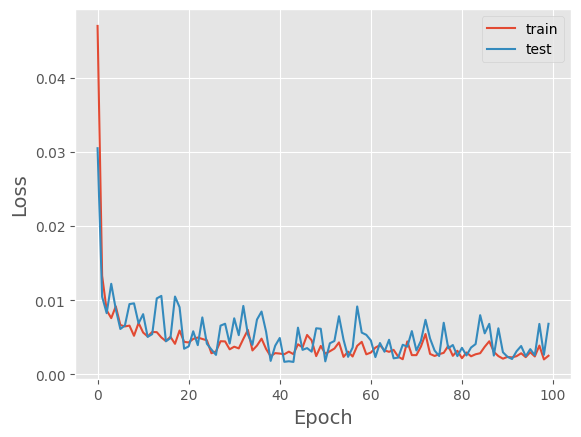

In [20]:
input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])
# Build and train the model using the build_lstm_model (new instance name lstm_model_scaled)
lstm_model_scaled = build_lstm_model(input_shape)
# Train the new model using train_model method as previousely using the new scaled data
train_model(lstm_model_scaled, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=100, batch_size=72, verbose=0)


1096/1096 [==============================] - 4s 3ms/step
RMSE: 8.135


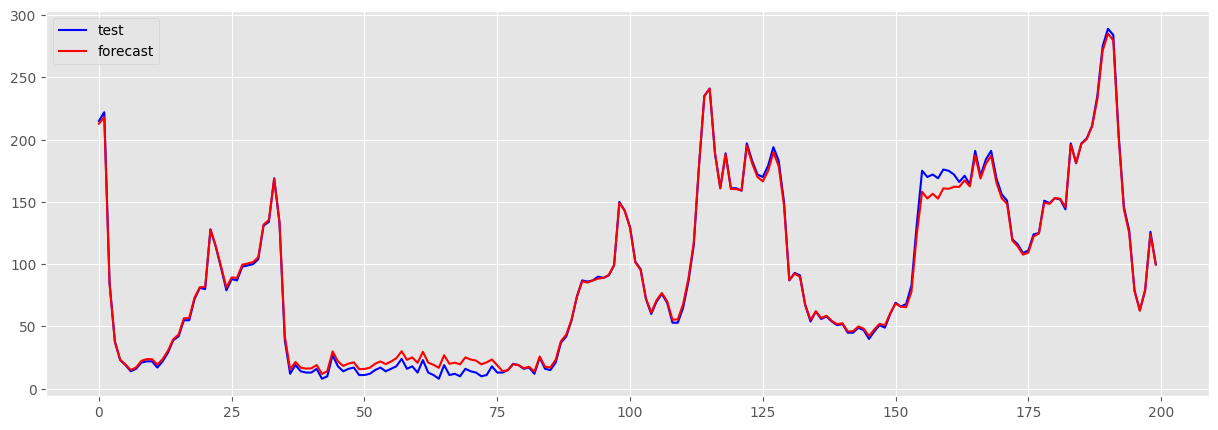

In [21]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_test_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]

# make a prediction
lstm_scaled_yhat = lstm_model_scaled.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, lstm_scaled_yhat)
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

When we scale the data, the RMSE signficantly decreases. To be sure the model is not overfitting, we need to add early stopping and some dropout during training. These regularization methods will help maintain the model's generalization performance and prevent it from learning noise or patterns specific to the training data.

#### Build a Stacked LSTM model

A Stacked LSTM model involves the stacking of multiple hidden LSTM layers on top of one another.

In [22]:
def build_stacked_lstm_model(input_shape, nb_neurons=50):
    model = Sequential()
    # Add an LSTM layer with nb_neurons and input_shape=input_shape and return_sequences=True (required sequences needed for next LSTM Bloc)
    model.add(LSTM(units=nb_neurons, input_shape=input_shape, return_sequences=True))
    # Add an additional LSTM layer with nb_neurons and 'relu' activation function 
    model.add(LSTM(units=nb_neurons, activation='relu'))
    # Add a Dense layer with one output neuron
    model.add(Dense(units=1))
    # Train the model
    return model

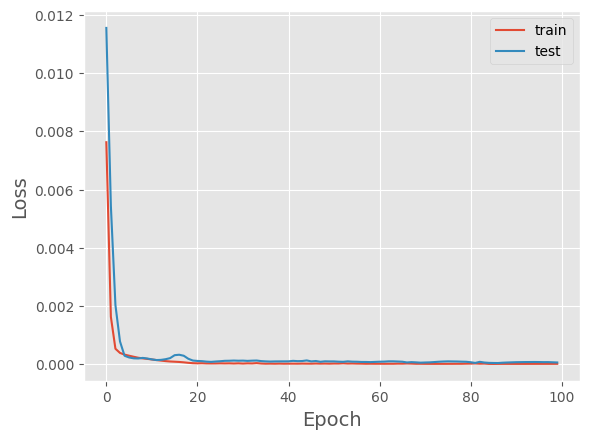

In [23]:
# Set input_shape
input_shape = (scaled_train_X.shape[1], scaled_train_X.shape[2]) 

# Build the new stacked_lstm_model
stacked_lstm_model = build_stacked_lstm_model(input_shape=input_shape, nb_neurons=50)

# Compile the model with mean squared error (MSE) as the loss function and Adam as the optimizer
stacked_lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model stacked_lstm_model
train_model(stacked_lstm_model,scaled_train_X, scaled_train_y,scaled_test_X,scaled_test_y , epochs=100, batch_size=72, verbose=0)


1096/1096 [==============================] - 4s 3ms/step
RMSE: 7.703


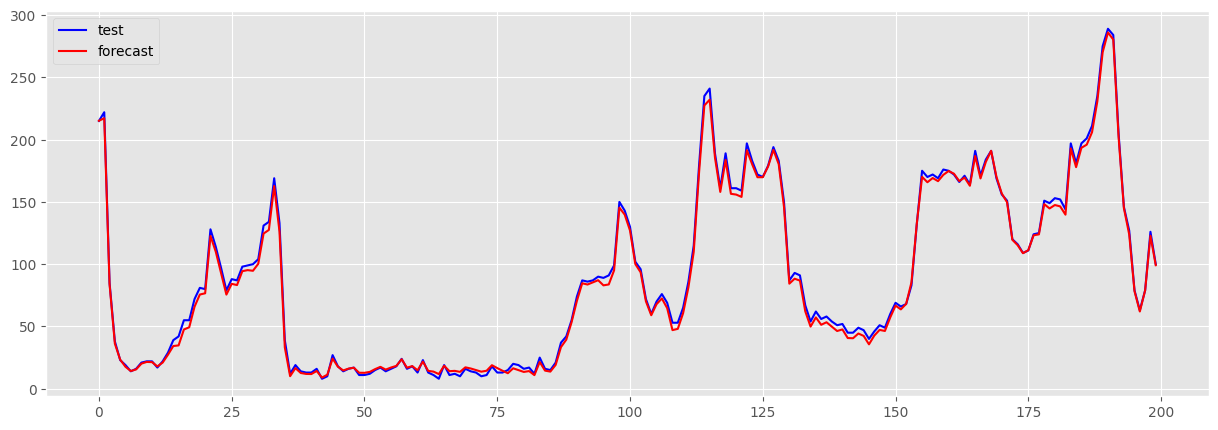

In [24]:
# make a prediction with stacked_lstm_model using scaled_test_X (output in variable scaled_stacked_lstm_yhat)
scaled_stacked_lstm_yhat = stacked_lstm_model.predict(scaled_test_X)

# invert scaling on the predicted output to get the actual values
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_lstm_yhat)

# compute performance
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

### Stack LSTM with Dropout and Early Stopping

In [27]:
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import EarlyStopping

def train_model_early(model, train_X, train_y, test_X, test_y, epochs=500, batch_size=72, verbose=0):
    '''
    Generic function to train model
    '''
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

    # Train model with early stopping callback
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y),
                        verbose=verbose, shuffle=False, callbacks=[early_stopping])

    # Plot loss history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    
    plt.legend()
    plt.show()



def build_stacked_lstm_model_early(input_shape, nb_neurons=50):
    model = Sequential()
    # Add an LSTM layer with nb_neurons and input_shape=input_shape and return_sequences=True (required sequences needed for next LSTM Bloc)
    model.add(LSTM(units=nb_neurons, input_shape=input_shape, return_sequences=True))
    # Add dropout layer with dropout rate of 0.2
    model.add(Dropout(0.2))
    # Add an additional LSTM layer with nb_neurons and 'relu' activation function 
    model.add(LSTM(units=nb_neurons, activation='relu'))
    # Add a Dense layer with one output neuron
    model.add(Dense(units=1))
    return model



Restoring model weights from the end of the best epoch: 52.
Epoch 72: early stopping


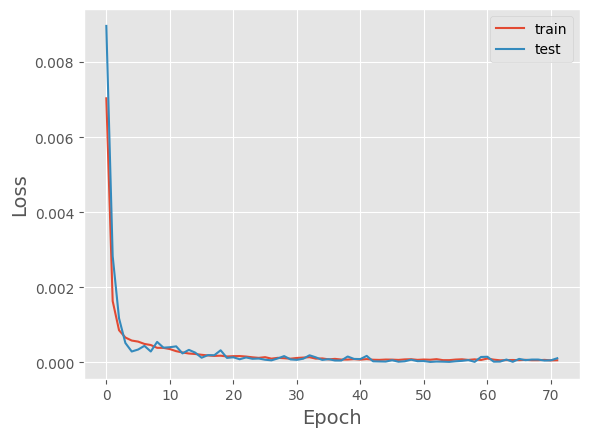

In [28]:
# Build the stacked LSTM model with early stopping
stacked_lstm_model_early = build_stacked_lstm_model_early(input_shape=(train_X.shape[1], train_X.shape[2]), nb_neurons=50)

stacked_lstm_model_early.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
train_model_early(stacked_lstm_model_early, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=100, batch_size=64, verbose=0)


1096/1096 [==============================] - 5s 4ms/step
RMSE: 3.208


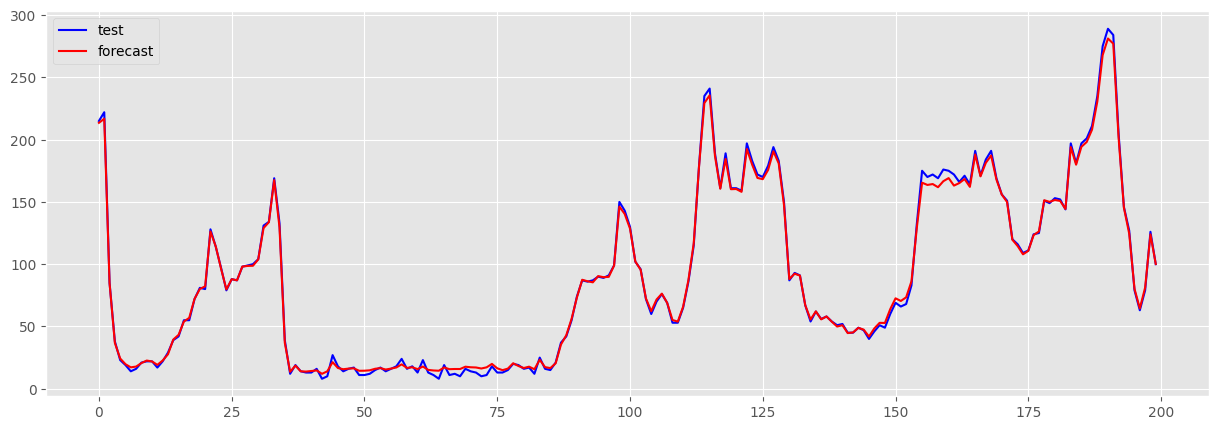

In [29]:
# make a prediction with stacked_lstm_model using scaled_test_X (output in variable scaled_stacked_lstm_yhat)
scaled_stacked_lstm_early_yhat = stacked_lstm_model_early.predict(scaled_test_X)

# invert scaling on the predicted output to get the actual values
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_lstm_early_yhat)

# compute performance
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

Incorporating early stopping with dropout, the model demonstrates an improvement with an RMSE of 3.208

## Improving the Performance 

We can try different strategies such as:
* Hyperparameters tuning
* Test other models: 1D-ConvNet LSTM, Bidirectional, GRU, etc. 

Here we will look at the Bidirectional LSTM and GRU. 


## Bidirectional LSTM with Early Stopping

Bidirectional LSTM (BiLSTM) is a type of recurrent neural network (RNN) architecture that process data in both forward and backward directions. This enables it to gather contextual information from both preceding and subsequent timesteps.

When combining Bidirectional LSTM with Early Stopping, one is essentially training a bidirectional recurrent model while monitoring its performance on a validation dataset. The training process is stopped early (before completing all epochs) if the performance on the validation dataset starts to degrade, indicating that the model is overfitting.

In [30]:
from keras.layers import Bidirectional

def build_bidirectional_lstm_model(input_shape, nb_neurons=50):
    model = Sequential()
    # Add a Bidirectional LSTM layer with nb_neurons and input_shape=input_shape and return_sequences=True (required sequences needed for next LSTM Bloc)
    model.add(Bidirectional(LSTM(units=nb_neurons, input_shape=input_shape, return_sequences=True)))
    model.add(Dropout(0.2))
    # Add an additional Bidirectional LSTM layer with nb_neurons and 'relu' activation function 
    model.add(Bidirectional(LSTM(units=nb_neurons, activation='relu')))
    # Add a Dense layer with one output neuron
    model.add(Dense(units=1))
    # Train the model
    return model


Restoring model weights from the end of the best epoch: 55.
Epoch 75: early stopping


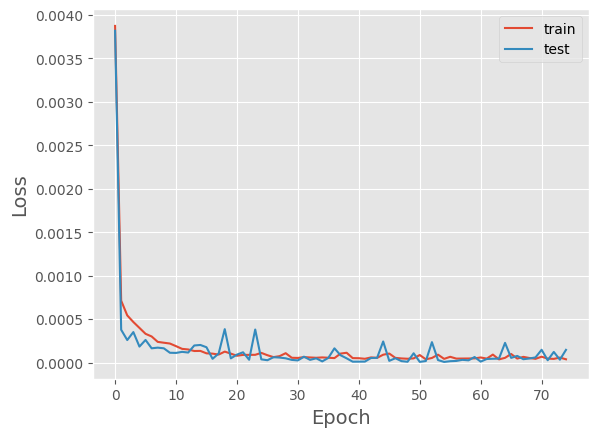

In [31]:
# Set input_shape
input_shape = (scaled_train_X.shape[1], scaled_train_X.shape[2]) 

# Build the new bidirectional_lstm_model
bidirectional_lstm_model = build_bidirectional_lstm_model(input_shape=input_shape, nb_neurons=50)

# Compile the model with mean squared error (MSE) as the loss function and Adam as the optimizer
bidirectional_lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
train_model_early(bidirectional_lstm_model,scaled_train_X, scaled_train_y,scaled_test_X,scaled_test_y , epochs=100, batch_size=64, verbose=0)


1096/1096 [==============================] - 6s 4ms/step
RMSE: 2.672


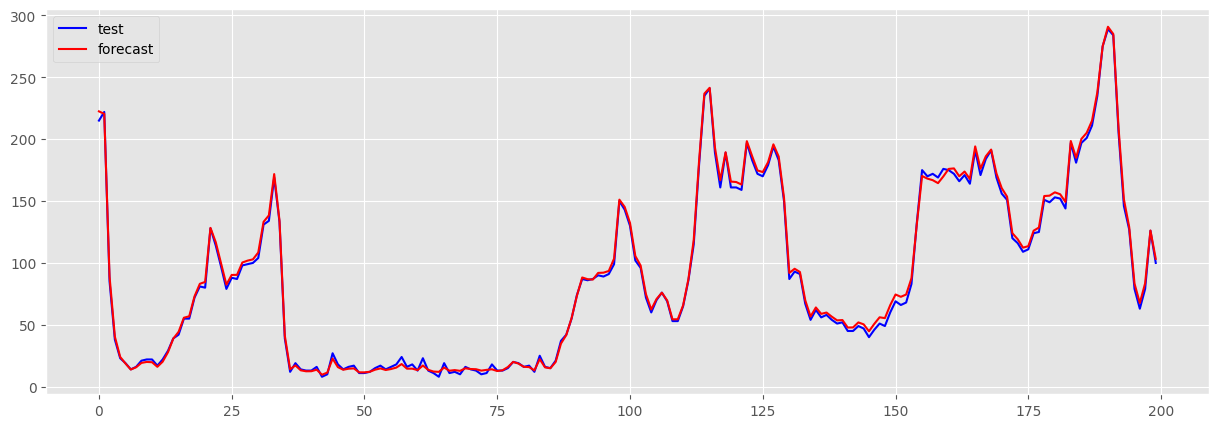

In [32]:
# make a prediction with bidirectional_lstm_model using scaled_test_X (output in variable scaled_stacked_bi_lstm_yhat)
scaled_stacked_bi_lstm_yhat = bidirectional_lstm_model.predict(scaled_test_X)

# invert scaling on the predicted output to get the actual values
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_bi_lstm_yhat)

# compute performance
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)


The best model is the Bidirectional lstm model with Dropout and Early stopping. The model outperforms other models with a RMSE of 2.672

## NAIVE GRID SEARCH

"Naive grid search" refers to a basic or straightforward approach in hyperparameter tuning for machine learning models using a grid search technique. In hyperparameter tuning, you have a set of hyperparameters for a model, and you need to find the combination of hyperparameter values that gives the best performance.

A grid search involves defining a grid of hyperparameter values and then evaluating the model performance for each combination of these values. The "naive" aspect comes in when you exhaustively search through all possible combinations without any optimization or sophistication. It essentially involves trying every combination in a systematic way.

While a naive grid search is simple to implement and conceptually easy to understand, it may not be the most efficient method, especially when dealing with a large number of hyperparameters or a vast search space since takes longer to run till the end. 

Here we will use the naive grid search to find the best hyperparameters for our Bidirectional lstm model.






Restoring model weights from the end of the best epoch: 30.
Epoch 50: early stopping


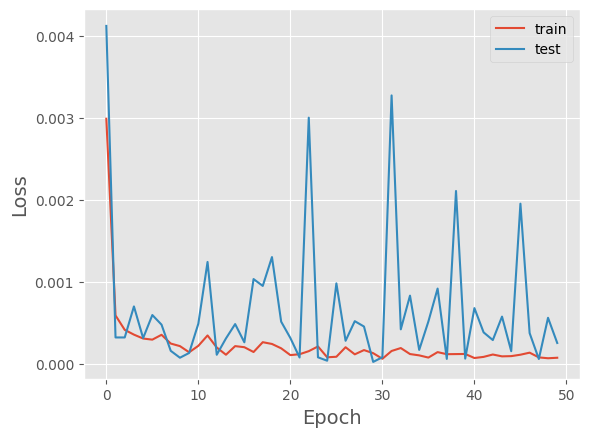

1096/1096 [==============================] - 6s 4ms/step
Neurons: 50, Batch size: 32, Epochs: 100, Test RMSE: 131.053
Restoring model weights from the end of the best epoch: 21.
Epoch 41: early stopping


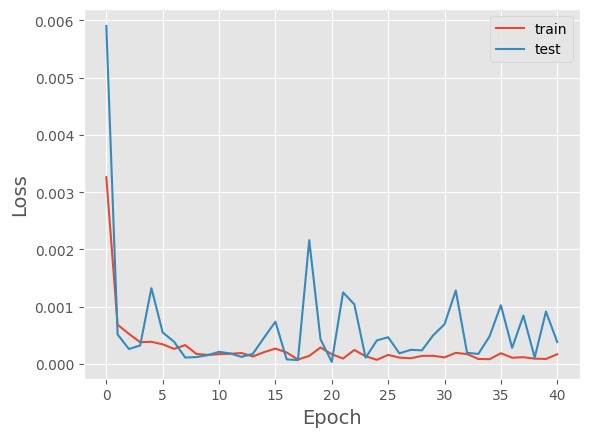

1096/1096 [==============================] - 6s 4ms/step
Neurons: 50, Batch size: 32, Epochs: 200, Test RMSE: 131.057
Restoring model weights from the end of the best epoch: 30.
Epoch 50: early stopping


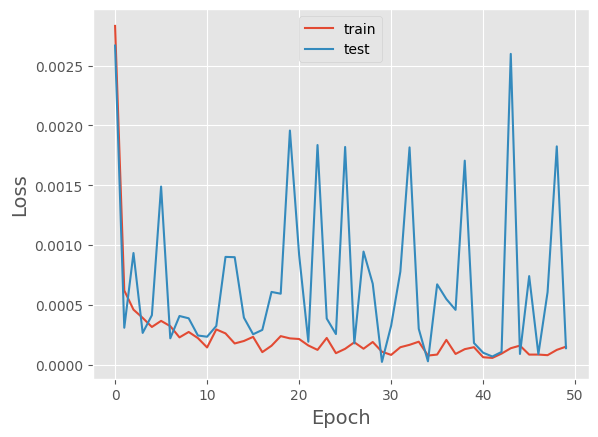

1096/1096 [==============================] - 6s 4ms/step
Neurons: 50, Batch size: 32, Epochs: 300, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 25.
Epoch 45: early stopping


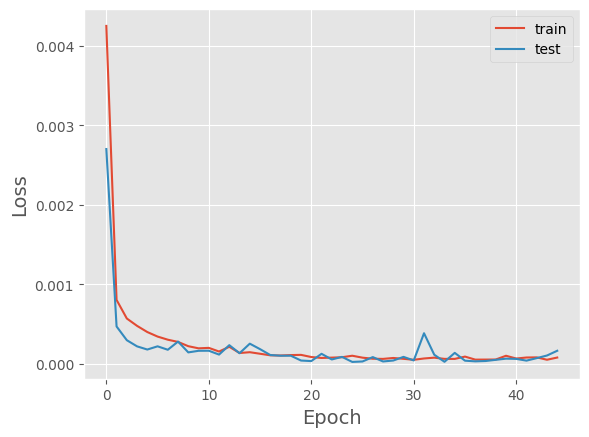

1096/1096 [==============================] - 6s 4ms/step
Neurons: 50, Batch size: 64, Epochs: 100, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 53.
Epoch 73: early stopping


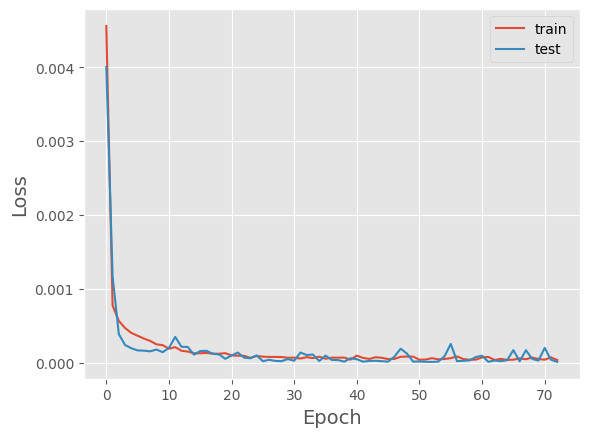

1096/1096 [==============================] - 6s 4ms/step
Neurons: 50, Batch size: 64, Epochs: 200, Test RMSE: 131.057
Restoring model weights from the end of the best epoch: 65.
Epoch 85: early stopping


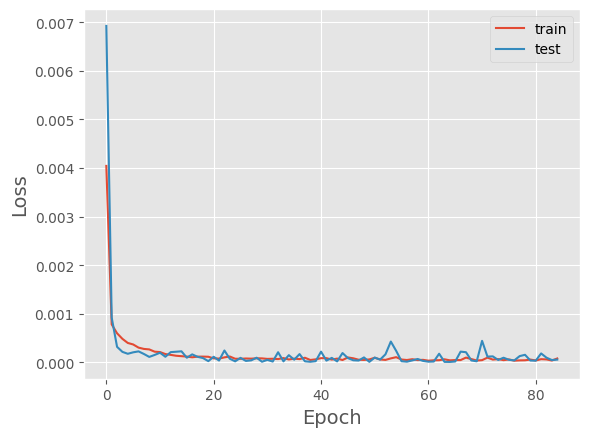

1096/1096 [==============================] - 7s 4ms/step
Neurons: 50, Batch size: 64, Epochs: 300, Test RMSE: 131.056
Restoring model weights from the end of the best epoch: 30.
Epoch 50: early stopping


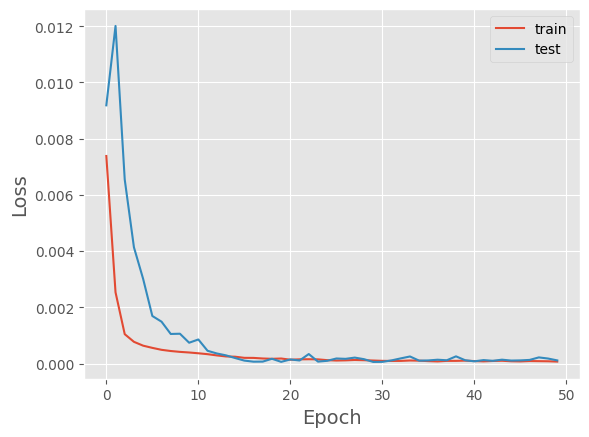

1096/1096 [==============================] - 6s 4ms/step
Neurons: 50, Batch size: 128, Epochs: 100, Test RMSE: 131.054
Restoring model weights from the end of the best epoch: 22.
Epoch 42: early stopping


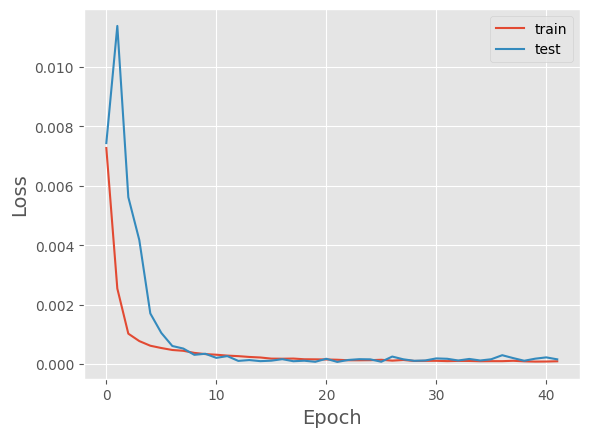

1096/1096 [==============================] - 5s 3ms/step
Neurons: 50, Batch size: 128, Epochs: 200, Test RMSE: 131.054
Restoring model weights from the end of the best epoch: 18.
Epoch 38: early stopping


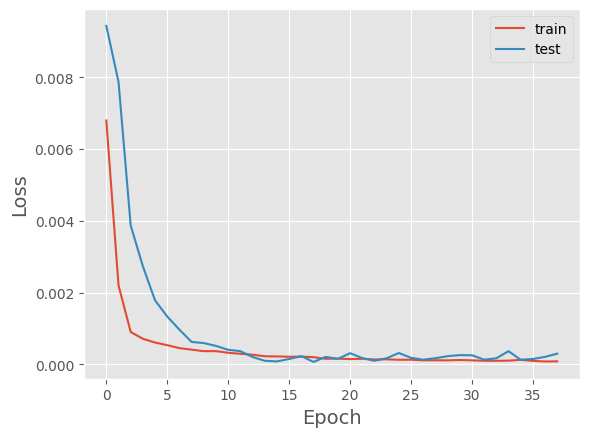

1096/1096 [==============================] - 5s 3ms/step
Neurons: 50, Batch size: 128, Epochs: 300, Test RMSE: 131.053
Restoring model weights from the end of the best epoch: 9.
Epoch 29: early stopping


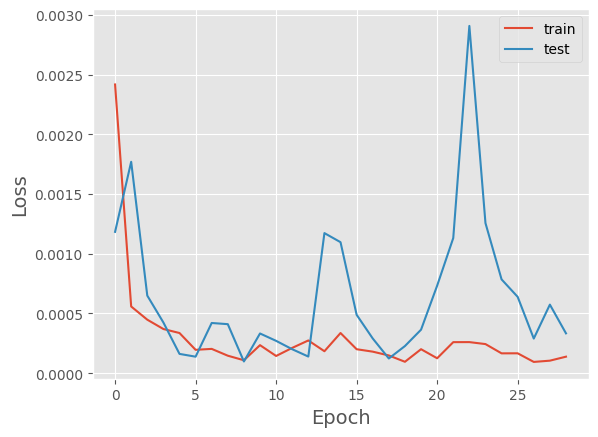

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 32, Epochs: 100, Test RMSE: 131.057
Restoring model weights from the end of the best epoch: 37.
Epoch 57: early stopping


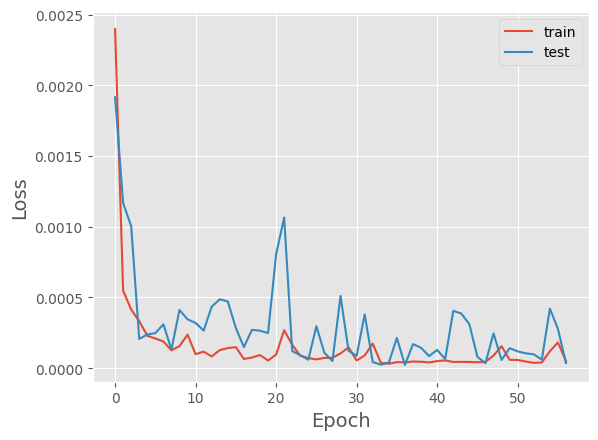

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 32, Epochs: 200, Test RMSE: 131.053
Restoring model weights from the end of the best epoch: 57.
Epoch 77: early stopping


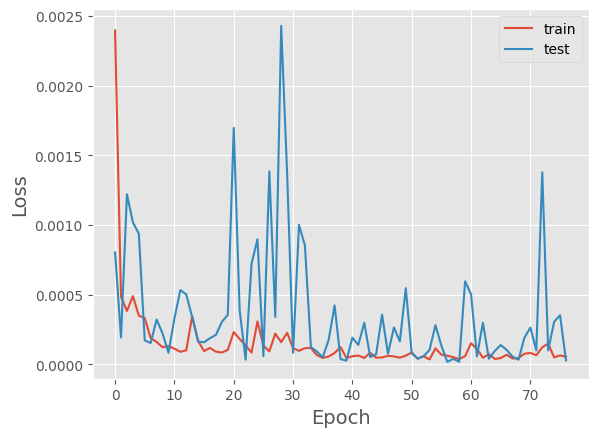

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 32, Epochs: 300, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 21.
Epoch 41: early stopping


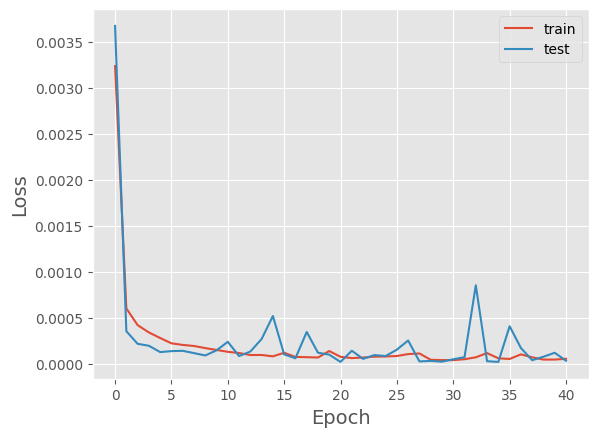

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 64, Epochs: 100, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 38.
Epoch 58: early stopping


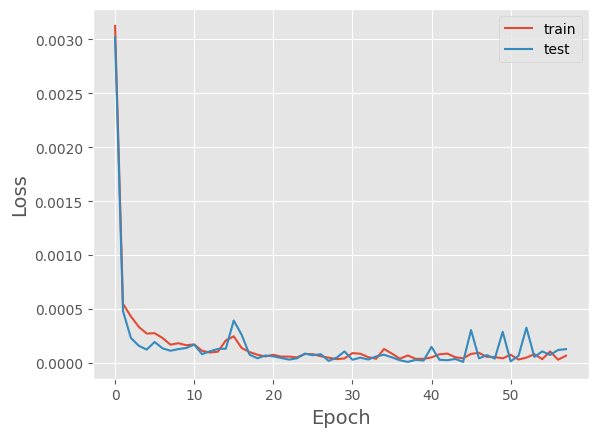

1096/1096 [==============================] - 4s 3ms/step
Neurons: 100, Batch size: 64, Epochs: 200, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 59.
Epoch 79: early stopping


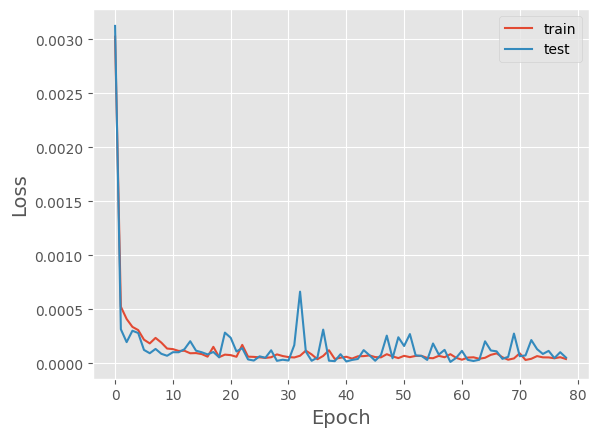

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 64, Epochs: 300, Test RMSE: 131.056
Restoring model weights from the end of the best epoch: 27.
Epoch 47: early stopping


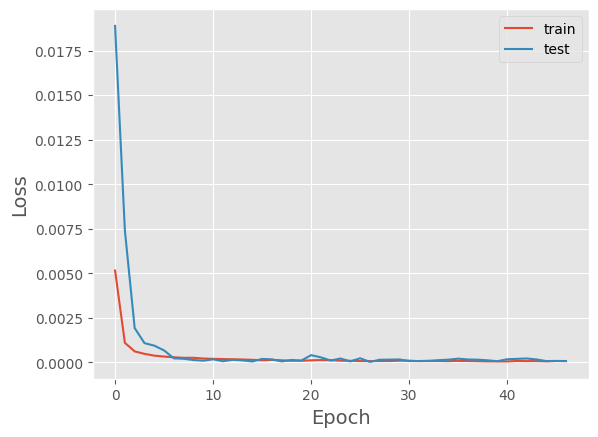

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 128, Epochs: 100, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 28.
Epoch 48: early stopping


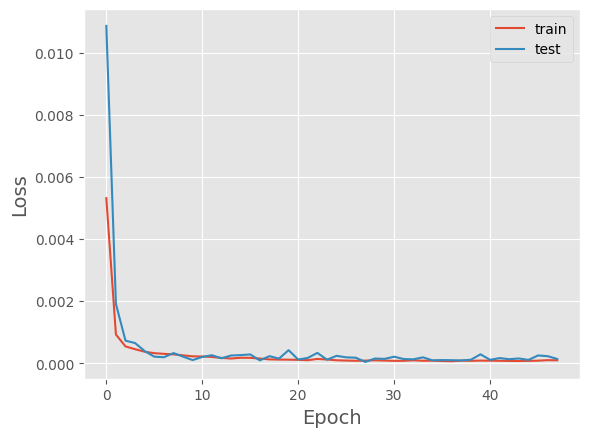

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 128, Epochs: 200, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 18.
Epoch 38: early stopping


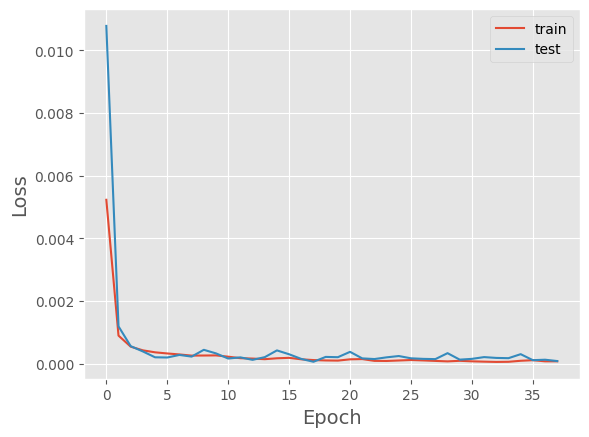

1096/1096 [==============================] - 6s 4ms/step
Neurons: 100, Batch size: 128, Epochs: 300, Test RMSE: 131.055
Restoring model weights from the end of the best epoch: 30.
Epoch 50: early stopping


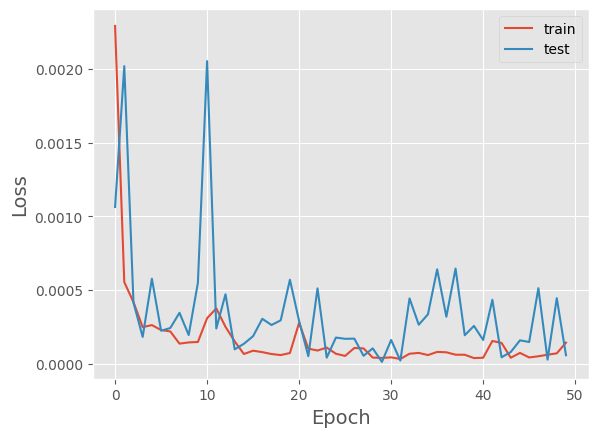

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 32, Epochs: 100, Test RMSE: 131.054
Restoring model weights from the end of the best epoch: 105.
Epoch 125: early stopping


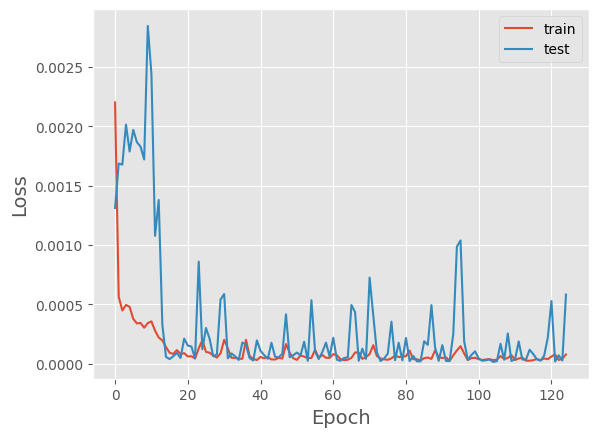

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 32, Epochs: 200, Test RMSE: 131.054
Restoring model weights from the end of the best epoch: 32.
Epoch 52: early stopping


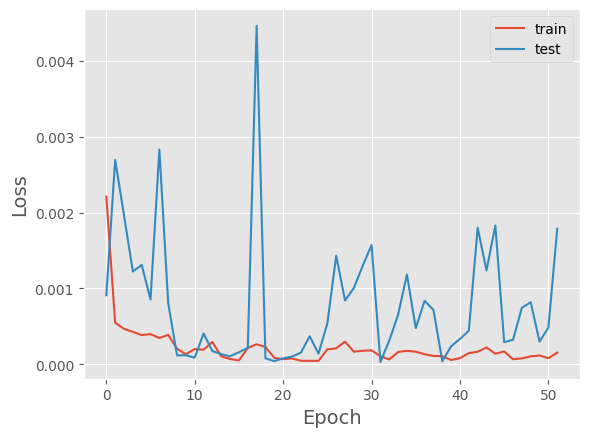

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 32, Epochs: 300, Test RMSE: 131.052
Restoring model weights from the end of the best epoch: 26.
Epoch 46: early stopping


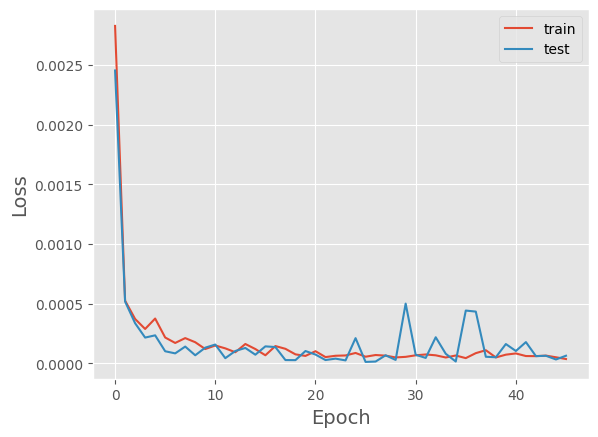

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 64, Epochs: 100, Test RMSE: 131.053
Restoring model weights from the end of the best epoch: 24.
Epoch 44: early stopping


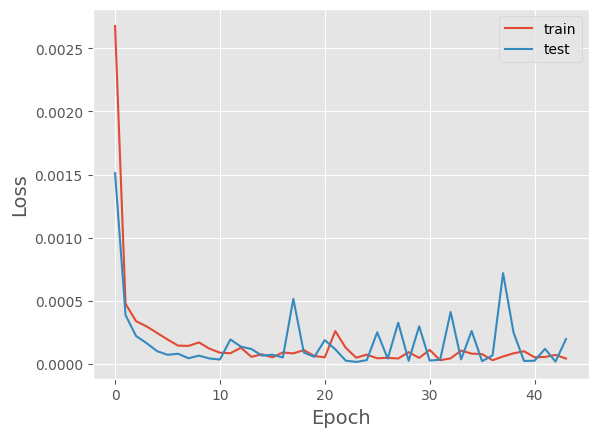

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 64, Epochs: 200, Test RMSE: 131.054
Restoring model weights from the end of the best epoch: 38.
Epoch 58: early stopping


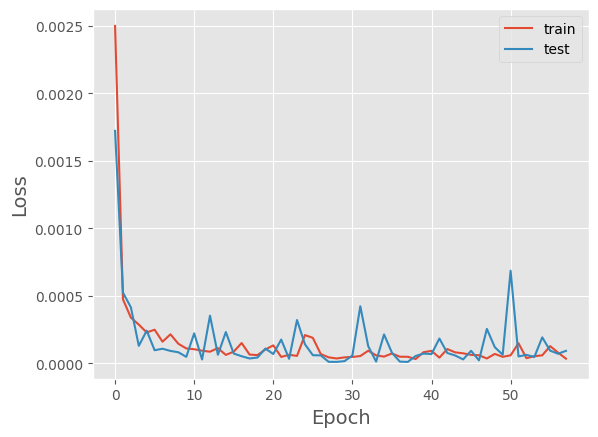

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 64, Epochs: 300, Test RMSE: 131.053
Restoring model weights from the end of the best epoch: 25.
Epoch 45: early stopping


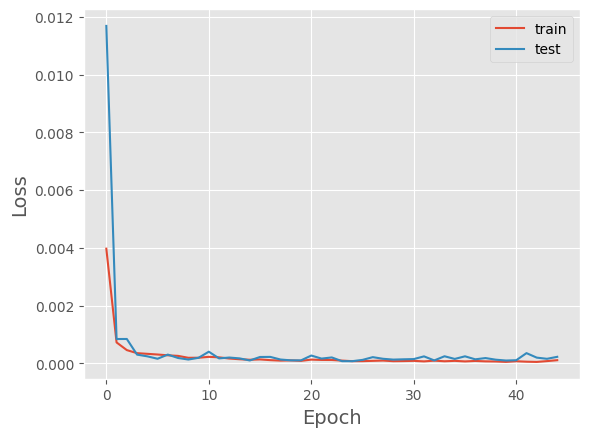

1096/1096 [==============================] - 6s 4ms/step
Neurons: 150, Batch size: 128, Epochs: 100, Test RMSE: 131.058
Restoring model weights from the end of the best epoch: 26.
Epoch 46: early stopping


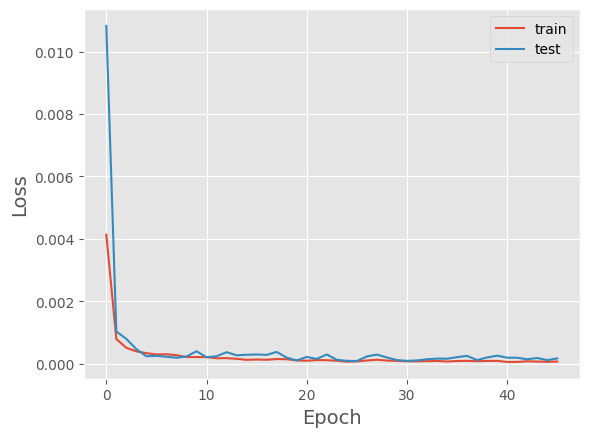

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 128, Epochs: 200, Test RMSE: 131.059
Restoring model weights from the end of the best epoch: 77.
Epoch 97: early stopping


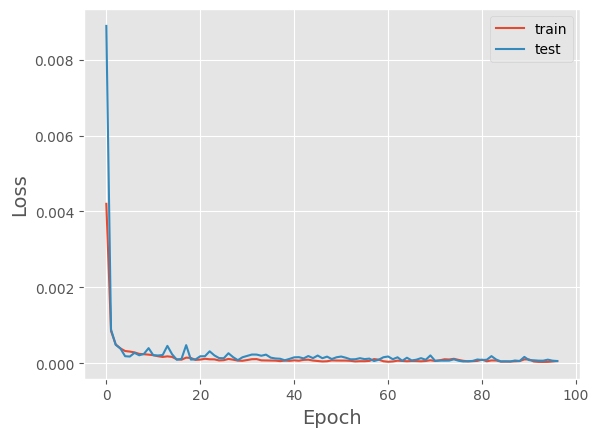

1096/1096 [==============================] - 7s 5ms/step
Neurons: 150, Batch size: 128, Epochs: 300, Test RMSE: 131.055
Best hyperparameters: Neurons: 150, Batch size: 32, Epochs: 300, Test RMSE: 131.052


In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define hyperparameters to test
neurons_list = [50, 100, 150]
batch_size_list = [32, 64, 128]
epochs_list = [100, 200, 300]

best_rmse = float('inf')
best_hyperparams = None

for neurons in neurons_list:
  for batch_size in batch_size_list:
    for epochs in epochs_list:
      # Build the model
      input_shape = (train_X.shape[1], train_X.shape[2])
      model = build_bidirectional_lstm_model(input_shape, nb_neurons=neurons)
      # Compile the model with mean squared error (MSE) as the loss function and Adam as the optimizer
      model.compile(loss='mean_squared_error', optimizer='adam')
      # Train the model
      train_model_early(model, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=epochs, batch_size=batch_size, verbose=0)

      # Make predictions on test data
      yhat = model.predict(scaled_test_X)

      # Calculate RMSE
      rmse = sqrt(mean_squared_error(test_y, yhat))

      # Check if this is the best RMSE so far
      if rmse < best_rmse:
        best_rmse = rmse
        best_hyperparams = (neurons, batch_size, epochs)

      print('Neurons: %d, Batch size: %d, Epochs: %d, Test RMSE: %.3f' % (neurons, batch_size, epochs, rmse))

print('Best hyperparameters: Neurons: %d, Batch size: %d, Epochs: %d, Test RMSE: %.3f' % (best_hyperparams[0], best_hyperparams[1], best_hyperparams[2], best_rmse))


Best hyperparameters for the bidirectional LSTM with early dropping are Neurons: 150, Batch size: 32, Epochs: 300, Test RMSE: 131.052 

## Gated Recurrent Unit (GRU)

A Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) architecture, specifically designed to address some of the limitations of traditional RNNs in capturing long-range dependencies in sequential data. It was introduced by Cho et al. in 2014.

The key feature of a GRU is its gating mechanism, which allows the network to selectively update information. It consists of two gates:

* Update Gate: It decides how much of the past information needs to be passed along to the future. If the update gate is close to 0, it means that the model should forget the past information, and if it's close to 1, it means that the model should remember the past information.

* Reset Gate: It decides how much of the past information to forget. If the reset gate is close to 0, it means that the model should forget the past information and focus on the new information.

The internal state of a GRU is updated based on the input, the previous hidden state, and the decisions made by the update and reset gates.

Compared to traditional RNNs, GRUs often perform better in practice due to their ability to capture long-range dependencies while being computationally more efficient. They are widely used in natural language processing tasks, time series analysis, and other sequential data applications.

In [34]:
def build_stacked_GRU_model(input_shape, nb_neurons = 50):
    model = Sequential()
    model.add((GRU(nb_neurons, input_shape=input_shape, return_sequences=True)))
    model.add((GRU(nb_neurons, activation='sigmoid',  return_sequences=True)))
    model.add((GRU(nb_neurons, activation='sigmoid',  return_sequences=True)))
    model.add((GRU(nb_neurons, activation='sigmoid',  return_sequences=True)))
    model.add((GRU(nb_neurons, activation='sigmoid')))
    model.add(Dense(1, activation='sigmoid'))

    return model


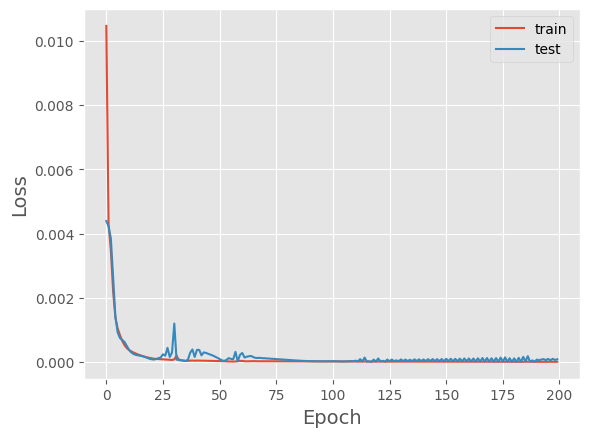

In [35]:
input_shape = (train_X.shape[1], train_X.shape[2]) 
# Build the new stacked_lstm_model
build_stacked_GRU_model=build_stacked_GRU_model(input_shape=input_shape, nb_neurons=50)

# Compile the model with mean squared error (MSE) as the loss function and Adam as the optimizer
build_stacked_GRU_model.compile(loss='log_cosh', optimizer='adam')

# Train the model stacked_GRU_model
train_model(build_stacked_GRU_model, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y , epochs=200, batch_size=64, verbose=0)

1096/1096 [==============================] - 7s 5ms/step
RMSE: 13.052


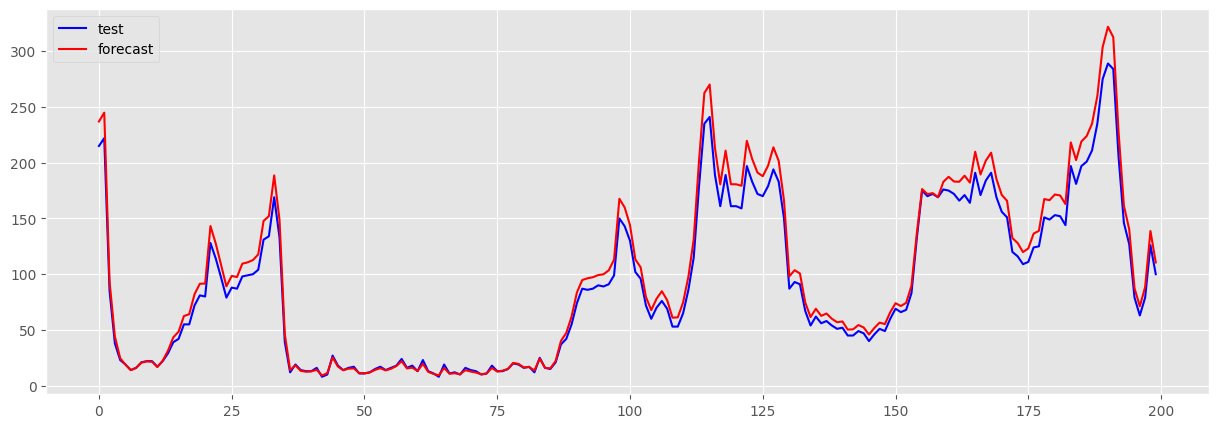

In [36]:
stacked_GRU_model_yhat = build_stacked_GRU_model.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, stacked_GRU_model_yhat)
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)